# Enhanced SimCLR

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from torch.optim import lr_scheduler

# Configuration
device = "cuda:0"
num_epochs = 5
num_folds = 10
batch_size = 58
feature_dim = 2048
num_classes = 13
root_dir = './spectrograms'
csv_file = "./spectrograms_balanced_no_sirens.csv"

# Get class names
full_annotations = pd.read_csv(csv_file)
class_names = sorted(full_annotations['classID'].unique())

# Dataset Class
class UrbanSoundDataset(Dataset):
    def __init__(self, root_dir, folds, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.annotations = pd.read_csv(csv_file)

        if isinstance(folds, int):
            folds = [folds]
        self.file_list = self.annotations[self.annotations['fold'].isin(folds)]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        row = self.file_list.iloc[idx]
        img_path = os.path.join(self.root_dir, f'fold{row["fold"]}', row['spec_file_name'])
        image = Image.open(img_path).convert('RGB')
        label = row['classID']

        if self.transform:
            xi = self.transform(image)
            xj = self.transform(image)
            return xi, xj, label
        return image, label


# Model Components
class ProjectionHead(torch.nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=512, output_dim=128):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

class SimCLR(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection = ProjectionHead()
    def forward(self, x):
        features = self.backbone(x)
        return self.projection(features)

class Classifier(torch.nn.Module):
    def __init__(self, input_dim=2048, num_classes=13):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

# Loss Function
class NTXentLoss(torch.nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        N = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix
        sim = torch.mm(z, z.T) / self.temperature

        # Create labels: positives are the N off-diagonal elements
        labels = torch.cat([
            torch.arange(N, 2*N, device=z.device),
            torch.arange(0, N, device=z.device)
        ])

        # Mask out self-similarity
        mask = torch.eye(2*N, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(mask, -1e9)

        # Compute loss
        loss = self.criterion(sim, labels)
        return loss

#tried but does work require more memeory with batch size 64
# def mixup_data(x1, x2, y1, y2, alpha=0.2):
#     '''Returns mixed inputs, pairs of targets, and lambda'''
#     lam = np.random.beta(alpha, alpha)
#     batch_size = x1.size(0)
#     index = torch.randperm(batch_size).cuda()

#     mixed_x = lam * x1 + (1 - lam) * x2
#     y_a, y_b = y1, y2
#     return mixed_x, y_a, y_b, lam

# Training Function with Mixup and CosineAnnealingLR
def train():
    # Initialize backbone
    backbone = models.resnet50(pretrained=True)
    backbone.fc = torch.nn.Identity()
    simclr = SimCLR(backbone).to(device)
    classifier = Classifier().to(device)
    criterion = NTXentLoss()

    # Data transformations
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
    ])

    # K-fold cross-validation
    for fold in range(6, num_folds+1):
        print(f"\n{'='*40}")
        print(f"=== Fold {fold}/{num_folds} {'='*20}")
        print(f"{'='*40}\n")

        # Data loaders
        train_ds = UrbanSoundDataset(root_dir, [f for f in range(1,11) if f != fold],
                                   csv_file, transform)
        val_ds = UrbanSoundDataset(root_dir, [fold], csv_file, transform)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4)

        # Model components

        #load the model till 4th fold and contnious training


        if fold == 6:
            checkpoint_dir = 'checkpoints'
            checkpoint_path = os.path.join(checkpoint_dir, 'fold_5_checkpoint.pth')
            checkpoint = torch.load(checkpoint_path)
            simclr.load_state_dict(checkpoint['simclr'])
            classifier.load_state_dict(checkpoint['classifier'])

            continue
        else:
          # Cosine Annealing learning rate scheduler
          optimizer = torch.optim.Adam(list(simclr.parameters()) + list(classifier.parameters()), lr=3e-4)

          scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

          # Metrics storage
          train_losses, val_losses = [], []
          val_accuracies, all_preds, all_labels = [], [], []

          for epoch in range(num_epochs):
              print(f"\nEpoch {epoch+1}/{num_epochs}")

              # Training Phase
              simclr.train()
              classifier.train()
              epoch_loss = 0
              batch_count = 0

              for batch_idx, (xi, xj, labels) in enumerate(train_loader):
                  xi, xj, labels = xi.to(device), xj.to(device), labels.to(device)

                  # Forward pass
                  zi, zj = simclr(xi), simclr(xj)
                  loss_contrastive = criterion(zi, zj)

                  # Classification
                  features = simclr.backbone(xi)
                  logits = classifier(features)
                  loss_classification = torch.nn.functional.cross_entropy(logits, labels)

                  # Total loss
                  loss = loss_contrastive + 0.5 * loss_classification

                  # Backward pass
                  optimizer.zero_grad()
                  loss.backward()
                  optimizer.step()

                  # Progress tracking
                  epoch_loss += loss.item()
                  batch_count += 1

                  # Print batch updates
                  if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(train_loader):
                      current_lr = optimizer.param_groups[0]['lr']
                      print(f"  Batch {batch_idx + 1:03d}/{len(train_loader)} | "
                            f"Loss: {loss.item():.4f} | "
                            f"CLoss: {loss_contrastive.item():.4f} | "
                            f"FLoss: {loss_classification.item():.4f} | "
                            f"LR: {current_lr:.2e}")

              # Epoch statistics
              avg_train_loss = epoch_loss / batch_count
              train_losses.append(avg_train_loss)
              print(f"\n  Training Summary | Epoch {epoch+1}")
              print(f"  Avg Loss: {avg_train_loss:.4f}")
              print(f"  Last Batch Loss: {loss.item():.4f}")

              scheduler.step()

              # Validation Phase
              simclr.eval()
              classifier.eval()
              val_loss, correct, total = 0, 0, 0

              print("\n  Validating...")
              with torch.no_grad():
                  for batch_idx, (xi, _, labels) in enumerate(val_loader):
                      xi, labels = xi.to(device), labels.to(device)

                      # Forward pass
                      features = simclr.backbone(xi)
                      logits = classifier(features)

                      # Loss calculation
                      loss = torch.nn.functional.cross_entropy(logits, labels)
                      val_loss += loss.item()

                      # Accuracy calculation
                      preds = torch.argmax(logits, dim=1)
                      correct += (preds == labels).sum().item()
                      total += labels.size(0)

                      # Store predictions
                      all_preds.extend(preds.cpu().numpy())
                      all_labels.extend(labels.cpu().numpy())

                      # Validation batch updates
                      if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(val_loader):
                          acc = 100 * (preds == labels).sum().item() / labels.size(0)
                          print(f"    Val Batch {batch_idx + 1:03d}/{len(val_loader)} | "
                                f"Loss: {loss.item():.4f} | "
                                f"Batch Acc: {acc:.2f}%")

              # Validation statistics
              avg_val_loss = val_loss / len(val_loader)
              val_losses.append(avg_val_loss)
              val_acc = 100 * correct / total
              val_accuracies.append(val_acc)

              print(f"\n  Validation Summary | Epoch {epoch+1}")
              print(f"  Avg Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.2f}%")
              print(f"  Current Best Acc: {max(val_accuracies):.2f}%")

              # Step the scheduler

          # Fold Completion
          print(f"\n{'='*40}")
          print(f"=== Fold {fold} Completed ===")
          print(f"Best Validation Accuracy: {max(val_accuracies):.2f}%")
          checkpoint_dir = 'checkpoints'  # Or provide an absolute path like '/path/to/save'
          os.makedirs(checkpoint_dir, exist_ok=True)  # Create directory if it doesn't exist

          torch.save({
                'simclr': simclr.state_dict(),
                'classifier': classifier.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, os.path.join(checkpoint_dir, f'fold_{fold}_checkpoint.pth'))


if __name__ == "__main__":
    train()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



=== Fold 6/10 ====================


=== Fold 7/10 ====================


Epoch 1/5
  Batch 010/898 | Loss: 0.6353 | CLoss: 0.4222 | FLoss: 0.4263 | LR: 3.00e-04
  Batch 020/898 | Loss: 0.6061 | CLoss: 0.4200 | FLoss: 0.3723 | LR: 3.00e-04
  Batch 030/898 | Loss: 1.0534 | CLoss: 0.8360 | FLoss: 0.4349 | LR: 3.00e-04
  Batch 040/898 | Loss: 1.4819 | CLoss: 1.2143 | FLoss: 0.5351 | LR: 3.00e-04
  Batch 050/898 | Loss: 1.1093 | CLoss: 0.8156 | FLoss: 0.5874 | LR: 3.00e-04
  Batch 060/898 | Loss: 0.5918 | CLoss: 0.4491 | FLoss: 0.2854 | LR: 3.00e-04
  Batch 070/898 | Loss: 0.9009 | CLoss: 0.6663 | FLoss: 0.4692 | LR: 3.00e-04
  Batch 080/898 | Loss: 1.0772 | CLoss: 0.7979 | FLoss: 0.5586 | LR: 3.00e-04
  Batch 090/898 | Loss: 0.7491 | CLoss: 0.6050 | FLoss: 0.2882 | LR: 3.00e-04
  Batch 100/898 | Loss: 0.8057 | CLoss: 0.6129 | FLoss: 0.3856 | LR: 3.00e-04
  Batch 110/898 | Loss: 0.9331 | CLoss: 0.7025 | FLoss: 0.4611 | LR: 3.00e-04
  Batch 120/898 | Loss: 0.6231 | CLoss: 0.4802 | FLoss: 0

In [ ]:
spec = pd.read_csv('/content/spectrograms_balanced_no_sirens.csv')
spec.sort_values('classID').groupby('fold').apply(lambda x: x['classID'].unique())
spec.sort_values('classID')['class'].unique()
# spec[spec['classID'] == 11]

<ipython-input-53-61890aece928>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spec.sort_values('classID').groupby('fold').apply(lambda x: x['classID'].unique())


array(['air_conditioner', 'ambulance', 'car_horn', 'children_playing',
       'dog_bark', 'drilling', 'engine_idling', 'firetruck', 'gun_shot',
       'jackhammer', 'police', 'street_music', 'traffic'], dtype=object)

In [4]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import IPython.display as ipd
import pandas as pd

# Model Components (same as in training script)
class ProjectionHead(torch.nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=512, output_dim=128):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

class SimCLR(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection = ProjectionHead()
    def forward(self, x):
        features = self.backbone(x)
        return self.projection(features)

class Classifier(torch.nn.Module):
    def __init__(self, input_dim=2048, num_classes=13):
        super().__init__()
        self.fc = torch.nn.Linear(input_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

def process_audio(audio_path, sr=22050, duration=None, n_mels=224):
    """Process audio file to mel spectrogram"""
    # Load audio
    y, sr = librosa.load(audio_path, sr=sr, duration=duration)

    # Create mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048,
                                      hop_length=512, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Convert to image
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.tight_layout(pad=0)

    # Save temporarily and load as PIL
    temp_path = 'temp_spec.png'
    plt.savefig(temp_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    img = Image.open(temp_path).convert('RGB')
    if os.path.exists(temp_path):
        os.remove(temp_path)

    return img, y, sr

class AudioClassifier:
    def __init__(self, checkpoint_path, class_names, device=None):
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        print(f"Using device: {self.device}")

        # Initialize model components
        backbone = models.resnet50(pretrained=False)
        backbone.fc = torch.nn.Identity()

        self.simclr = SimCLR(backbone).to(self.device)
        self.classifier = Classifier().to(self.device)
        self.class_names = class_names

        # Load checkpoint
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        # Debug: print keys
        print(f"Checkpoint keys: {checkpoint.keys()}")

        self.simclr.load_state_dict(checkpoint['simclr'])
        self.classifier.load_state_dict(checkpoint['classifier'])

        # Set to evaluation mode
        self.simclr.eval()
        self.classifier.eval()

        # Define transforms (similar to validation transforms)
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
        ])

    def predict(self, audio_path, verbose=True):
        """Predict class for audio file"""
        if verbose:
            print(f"Processing audio: {audio_path}")

        # Process audio to spectrogram image
        # img, audio, sr = process_audio(audio_path)
        #extract the the img
        r = pd.read_csv('./spectrograms_balanced_no_sirens.csv')
        img = r[r['orig_file_name'] == audio_path].iloc[0]
        print(img)
        path= '/content/spectrograms/'+ 'fold'+str(img['fold']) + '/' + img['spec_file_name']
        print(path)
        img = Image.open(path).convert('RGB')

        # Apply transforms
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        # Get predictions
        with torch.no_grad():
            # Extract features
            features = self.simclr.backbone(img_tensor)

            # Get logits from classifier
            logits = self.classifier(features)

            # Convert to probabilities
            probs = torch.nn.functional.softmax(logits, dim=1).squeeze().cpu().numpy()

            print(probs)

        if verbose:
            # Print top 3 predictions
            top_indices = np.argsort(probs)[::-1][:3]  # Sort in descending order
            print("\nTop 3 predictions:")
            print(top_indices)

            for i, idx in enumerate(top_indices):
                print(f"{i+1}. {self.class_names[idx]}: {probs[idx]*100:.2f}%")

        return probs

def visualize_prediction(probs, class_names):
    """Visualize prediction with audio playback"""
    # Play audio
    # print("Audio sample:")
    # display(ipd.Audio(audio, rate=sr))

    # Plot waveform and probabilities
    plt.figure(figsize=(12, 6))

    # Waveform
    # plt.subplot(1, 2, 1)
    # plt.plot(np.linspace(0, len(audio)/sr, len(audio)), audio)
    # plt.title("Waveform")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Amplitude")

    # Class probabilities
    plt.subplot(1, 2, 2)
    indices = np.argsort(probs)[::-1]
    plt.barh(range(len(class_names)), [probs[i] for i in indices])
    plt.yticks(range(len(class_names)), [class_names[i] for i in indices])
    plt.title("Class Probabilities")
    plt.xlabel("Probability")
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Define class names (same as in training)
    class_names = ['air_conditioner', 'ambulance', 'car_horn', 'children_playing',
       'dog_bark', 'drilling', 'engine_idling', 'firetruck', 'gun_shot',
       'jackhammer', 'police', 'street_music', 'traffic']

    # Initialize classifier
    classifier = AudioClassifier(
        checkpoint_path='./checkpoints/fold_10_checkpoint.pth',
        class_names=class_names
    )

    # Predict
    audio_path = "75743-0-0-11.wav"  # Replace with your audio file
    probs = classifier.predict(audio_path)

    # Visualize
    # visualize_prediction(probs, class_names)

    # Get top prediction
    top_idx = np.argmax(probs)
    print(f"\nFinal prediction: {class_names[top_idx]} with {probs[top_idx]*100:.2f}% confidence")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading checkpoint from ./checkpoints/fold_10_checkpoint.pth
Checkpoint keys: dict_keys(['simclr', 'classifier', 'optimizer'])
Processing audio: 75743-0-0-11.wav
spec_file_name    75743-0-orig.png
orig_file_name    75743-0-0-11.wav
fsID                         75743
fold                             9
classID                          0
class              air_conditioner
augmentation              original
Name: 47838, dtype: object
/content/spectrograms/fold9/75743-0-orig.png
[9.9959117e-01 4.3854552e-08 1.7155821e-07 4.3200230e-06 1.6912589e-05
 1.0995423e-05 1.5801904e-04 1.8663379e-05 1.8172510e-07 1.9268055e-05
 1.7953918e-06 1.7802566e-04 3.9542076e-07]

Top 3 predictions:
[ 0 11  6]
1. air_conditioner: 99.96%
2. street_music: 0.02%
3. engine_idling: 0.02%

Final prediction: air_conditioner with 99.96% confidence


In [54]:
from tqdm import tqdm
import os
import torch
import pandas as pd
from tqdm import tqdm
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
from sklearn.model_selection import train_test_split

def predict_on_dataframe(df, model_path, class_names, image_dir='./spectrograms', save_results=True):
    """
    Predict classes for a set of images using a pre-trained model.

    Args:
        df: DataFrame containing the spectrogram file names and class names
        model_path: Path to the trained model checkpoint
        class_names: List of class names
        image_dir: Directory where spectrogram images are stored
        save_results: Whether to save the predictions to a CSV file

    Returns:
        predictions_df: DataFrame containing the predictions
    """
    backbone = models.resnet50(pretrained=False)
    backbone.fc = torch.nn.Identity()

    simclr = SimCLR(backbone).to("cuda:0")
    classifier = Classifier().to("cuda:0")

    checkpoint = torch.load(model_path, map_location="cuda:0")
    simclr.load_state_dict(checkpoint['simclr'])
    classifier.load_state_dict(checkpoint['classifier'])

    simclr.eval()
    classifier.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization for ResNet
    ])

    # Initialize list to store results
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_name = row['spec_file_name']
        true_class = row['classID']
        fold = row['fold']

        img_path = os.path.join(image_dir, f"fold{fold}", img_name)

        image = Image.open(img_path).convert("RGB")
        image = transform(image).unsqueeze(0).to("cuda:0")

        features = simclr.backbone(image)

        logits = classifier(features)

        probs = F.softmax(logits, dim=1)

        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs.max().item()


        results.append({
            'spec_file_name': img_name,
            'true_class': true_class,
            'pred_class': pred_class,
            'confidence': confidence,
            'probabilities': probs.cpu().detach().numpy().tolist()
        })


    predictions_df = pd.DataFrame(results)

    if save_results:
        predictions_df.to_csv('predictions.csv', index=False)

    return predictions_df


if __name__ == "__main__":

    class_names  = ['air_conditioner', 'ambulance', 'car_horn', 'children_playing',
       'dog_bark', 'drilling', 'engine_idling', 'firetruck', 'gun_shot',
       'jackhammer', 'police', 'street_music', 'traffic']

    model_checkpoint_path = '/content/checkpoints/fold_10_checkpoint.pth'


    predictions_df = predict_on_dataframe(test_df, model_checkpoint_path, class_names)
        # Optionally print or inspect results
    print(predictions_df.head())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 11584/11584 [04:03<00:00, 47.53it/s]


          spec_file_name  true_class  pred_class  confidence  \
0  7803284754-13-pa1.png          12           8    0.332234   
1   7802093679-12-n1.png          10          10    0.999359   
2  7801911300-12-sa2.png          10           8    0.509390   
3  7798879923-10-ts0.png           1           1    0.829199   
4   7798630186-10-n0.png           1          10    0.723252   

                                       probabilities  
0  [[7.309515240194742e-06, 0.18852150440216064, ...  
1  [[1.3022838174947537e-05, 3.881257271132199e-0...  
2  [[3.341061756145791e-06, 0.38381245732307434, ...  
3  [[4.111320706101651e-08, 0.8291988372802734, 0...  
4  [[4.7775876737432554e-05, 0.05374174565076828,...  


In [55]:
import pandas as pd

def calculate_top_n_accuracy_per_class(predictions_df, top_percent=1):
    """
    Calculate Top N% accuracy for each class based on maximum probabilities.

    Args:
        predictions_df: DataFrame containing predictions with 'pred_class', 'true_class', and 'probabilities' columns
        top_percent: The percentage (1, 5, 10) for Top N% accuracy

    Returns:
        DataFrame containing the Top N% accuracy for each class
    """
    top_n_accuracy = []

    print("Example probabilities from the DataFrame:")
    print(predictions_df['probabilities'].head())

    for class_name, group in predictions_df.groupby('true_class'):
        class_size = len(group)

        top_n_count = max(1, int(class_size * top_percent / 100))
        print(f"Class: {class_name}, Class Size: {class_size}, Top N Count: {top_n_count}")
        group['max_prob'] = group['probabilities'].apply(lambda x: max(x[0]) if isinstance(x, list) and isinstance(x[0], list) else max(x)).astype(float)

        print("Example max_prob values from the DataFrame:")
        print(group[['spec_file_name', 'max_prob']].head())

        if top_n_count > 0:
            top_n_group = group.nlargest(top_n_count, 'max_prob')

            correct_predictions = (top_n_group['pred_class'] == top_n_group['true_class']).sum()
            accuracy = (correct_predictions / top_n_count) * 100

            top_n_accuracy.append({
                'Class': class_name,
                f'Top {top_percent}% Accuracy': f"{accuracy:.2f}%"
            })
        else:
            top_n_accuracy.append({
                'Class': class_name,
                f'Top {top_percent}% Accuracy': "Not enough samples"
            })

    accuracy_df = pd.DataFrame(top_n_accuracy)

    accuracy_df = accuracy_df.sort_values(by='Class', ascending=True)

    return accuracy_df

top_5_accuracy_df = calculate_top_n_accuracy_per_class(predictions_df, top_percent=1)

print(top_5_accuracy_df.to_string(index=False))


top_5_accuracy_df = calculate_top_n_accuracy_per_class(predictions_df, top_percent=5)

print(top_5_accuracy_df.to_string(index=False))

top_10_accuracy_df = calculate_top_n_accuracy_per_class(predictions_df, top_percent=10)
print(top_10_accuracy_df.to_string(index=False))


Example probabilities from the DataFrame:
0    [[7.309515240194742e-06, 0.18852150440216064, ...
1    [[1.3022838174947537e-05, 3.881257271132199e-0...
2    [[3.341061756145791e-06, 0.38381245732307434, ...
3    [[4.111320706101651e-08, 0.8291988372802734, 0...
4    [[4.7775876737432554e-05, 0.05374174565076828,...
Name: probabilities, dtype: object
Class: 0, Class Size: 898, Top N Count: 8
Example max_prob values from the DataFrame:
      spec_file_name  max_prob
14  100852-0-sa0.png  0.751515
45   75743-0-ps1.png  0.336204
55  100852-0-ts0.png  0.709551
69  153261-0-ps1.png  0.995751
92  146709-0-sa0.png  0.977597
Class: 1, Class Size: 898, Top N Count: 8
Example max_prob values from the DataFrame:
            spec_file_name  max_prob
3    7798879923-10-ts0.png  0.829199
4     7798630186-10-n0.png  0.723252
22    7798628988-10-n1.png  0.568961
50  7798720632-10-orig.png  0.941548
58   7798715376-10-sa2.png  0.729578
Class: 2, Class Size: 808, Top N Count: 8
Example max_prob values fr

Unique true labels in predictions_df: [12 10  1  5 11  8  4  0  7  6  3  9  2]
Unique predicted labels in predictions_df: [ 8 10  1  4  7 11  6  5  3  9  0 12  2]

F1 Score per class:
               Class  F1 Score
0    air_conditioner  0.358025
1          ambulance  0.346187
2           car_horn  0.463436
3   children_playing  0.652062
4           dog_bark  0.252822
5           drilling  0.718130
6      engine_idling  0.485784
7          firetruck  0.619222
8           gun_shot  0.212550
9         jackhammer  0.694842
10            police  0.647059
11      street_music  0.392670
12           traffic  0.437500


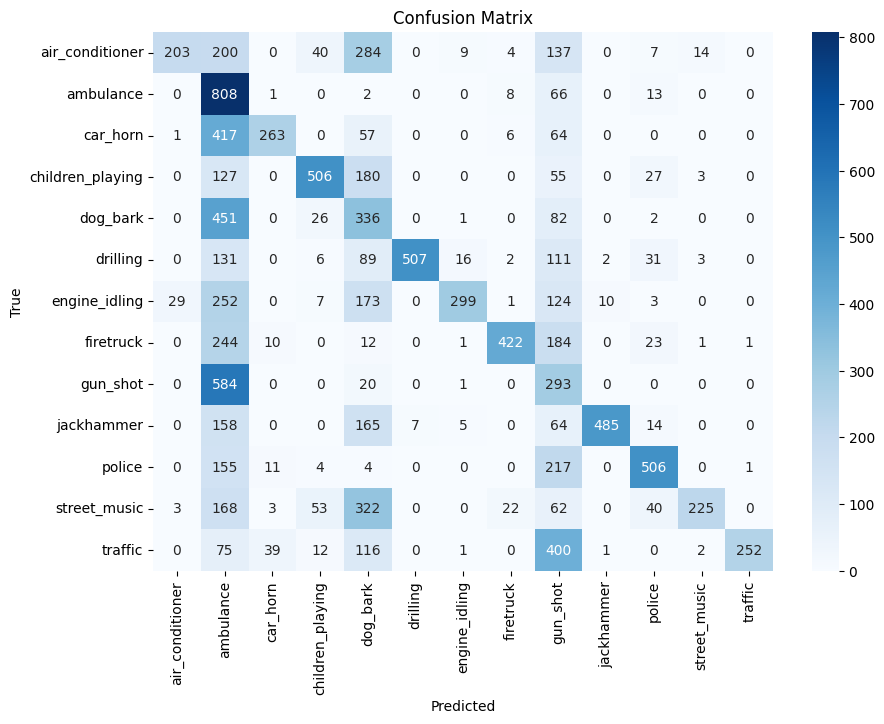

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix_and_f1(predictions_df, class_names):
    """
    Plot confusion matrix and calculate F1 score for each class.

    Args:
        predictions_df: DataFrame containing the predictions with 'true_class' and 'pred_class'
        class_names: List of all possible class names

    Returns:
        None
    """
    print("Unique true labels in predictions_df:", predictions_df['true_class'].unique())
    print("Unique predicted labels in predictions_df:", predictions_df['pred_class'].unique())

    missing_true_labels = predictions_df['true_class'].isnull().sum()
    missing_pred_labels = predictions_df['pred_class'].isnull().sum()
    if missing_true_labels > 0 or missing_pred_labels > 0:
        print(f"Warning: {missing_true_labels} missing true labels, {missing_pred_labels} missing predicted labels.")

    y_true = predictions_df['true_class'].values
    y_pred = predictions_df['pred_class'].values

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

    f1_scores = f1_score(y_true, y_pred, labels=np.arange(len(class_names)), average=None)

    f1_df = pd.DataFrame({
        'Class': class_names,
        'F1 Score': f1_scores
    })
    print("\nF1 Score per class:")
    print(f1_df)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix_and_f1(predictions_df, class_names)


In [18]:
from google.colab import files
files.download('checkpoint.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>